In [29]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.genmod.families import Poisson

from mri_data import file_manager as fm

In [30]:
# reload_recursive(helpers)

## Load Data

### Clinical and Volumes

In [35]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes-dilM_sphere2.csv",
                          index_col='subid')

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df['csf_peripheral'] = csf_volumes['peripheral']
df['csf_all'] = csf_volumes['all']
df['csf_peripheral_frac'] = csf_volumes['peripheral'] / csf_volumes['all']
df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["ventricle_logtrans"] = np.log(df["ventricle_volume"])

# these corrections should ultimately be made to the csf file
for struct in ["brain", "white", "grey", "thalamus", "t2lv"]:
    df[struct] = df[struct]*1000

df['CCF'] = df['ventricle_volume'] / df['csf_all']


df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

### HIPS-THOMAS Volumes and Distances

In [32]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

mni_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
    index_col="index",
)
mni_dists["struct"] = hips_thomas_ref

mni_dists2 = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
    index_col="index",
)
mni_dists2["struct"] = hips_thomas_ref

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
    index_col="index",
)
mni_ventricle_dists["struct"] = hips_thomas_ref


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


mni_combined_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv",
    index_col="index",
)

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

In [33]:
df['t2lv']

subid
1001     1433.965228
1002     1197.262277
1003     1896.614470
1004     1099.200521
1005     2645.443695
            ...     
3016     1205.552968
3017    10415.873200
3021     2186.487423
3023     4893.520521
3028     3990.667828
Name: t2lv, Length: 564, dtype: float64

## Functions

In [53]:
def normalize_by_tiv(df, variables=None):
    if variables is None:
        variables = ["brain", "white", "grey", "csf_all", "csf_peripheral", "ventricle_volume", "choroid_volume"]
    
    for var in variables:
        new_var = f"n-{var}"
        df[new_var] = df[var] / df['tiv']
    
    return df

def zscore(df):
    df_z = df.copy()
    numeric_cols = df.select_dtypes(include="number").columns
    df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")
    return df_z

## Analysis

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     240.8
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           4.67e-44
Time:                        15:11:54   Log-Likelihood:                -5059.2
No. Observations:                 467   AIC:                         1.012e+04
Df Residuals:                     465   BIC:                         1.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.441e+04   5044.560    -10.787      0.0

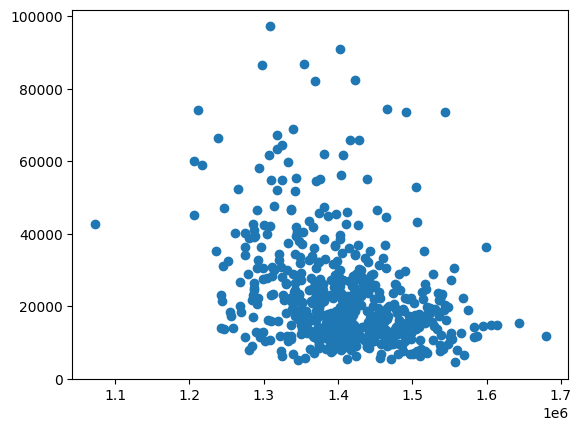

In [51]:
work_data = df[df['dz_type2'] == "MS"]
modelA = sm.OLS.from_formula("ventricle_volume ~ csf_all", data=work_data).fit()
modelB = sm.OLS.from_formula("ventricle_volume ~ csf_all + brain + age + Female + tiv", data=work_data).fit()

print(modelA.summary())
print(modelB.summary())

work_data['DVE'] = modelA.resid
plt.scatter(df['brain'], df['ventricle_volume'])

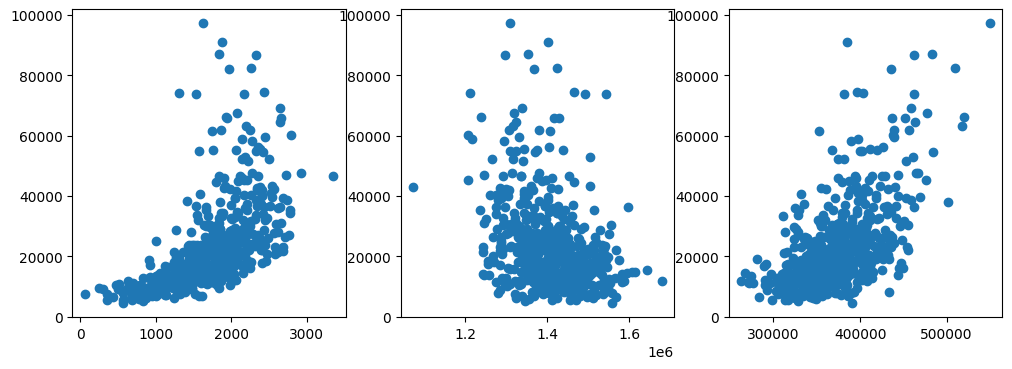

In [44]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

ax = axes[0]
ax.scatter(df['choroid_volume'], df['ventricle_volume'])

ax = axes[1]
ax.scatter(df['brain'], df['ventricle_volume'])

ax = axes[2]
ax.scatter(df['csf_all'], df['ventricle_volume'])


In [97]:
model_data = work_data.join([df_thomas2])
model_data = zscore(model_data)

model = sm.OLS.from_formula("ventricle_volume ~ csf_peripheral + choroid_volume + THALAMUS_1 + age + Female + tiv", data=model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     106.3
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           1.55e-83
Time:                        15:37:54   Log-Likelihood:                -456.36
No. Observations:                 465   AIC:                             926.7
Df Residuals:                     458   BIC:                             955.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0017      0.030     -0.

Ventricle volume as outcome, csf_peripheral is not significant while white is a covariate, but choroid volume is. Grey isnt important

In [31]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type3']=="MS"]

formula = "ventricle_volume ~ choroid_volume + white + age + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     58.33
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           5.52e-47
Time:                        02:45:38   Log-Likelihood:                -558.90
No. Observations:                 467   AIC:                             1130.
Df Residuals:                     461   BIC:                             1155.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0293      0.037      0.

In [38]:
df['tiv']

subid
1001    1491310.000
1002    1457902.875
1003    1474545.000
1004    1256718.250
1005    1325065.500
           ...     
3016    1236729.250
3017    1652912.875
3021    1558369.500
3023    1451392.750
3028    1525758.750
Name: tiv, Length: 564, dtype: float64